---
title: "Decision Tree - Classification"
format:
  html:
    toc: true
    code-fold: true
---

## Understanding Decision Trees(DT) and Random Forest(RF)

### Decision Trees (DT)

Imagine you're trying to decide where to go on vacation and you have a method of making that decision by asking a series of yes-or-no questions. These might involve considerations like whether you want a beach or a mountain, hot or cold weather, or if you're looking for adventure or relaxation. Decision Trees work in a very similar way to make predictions or decisions. They split data into branches at each level based on some criteria, with the goal of arriving at a decision by the time you reach the bottom of the tree.

In the context of predicting wildfires, a Decision Tree would look at historical climate data—like temperature, humidity, and wind speed—and learn a series of questions to accurately classify days when a wildfire occurred versus when it did not. The "questions" are based on the features of the data and are selected to best separate the days into two groups: high risk and low risk for a wildfire.

### Random Forest (RF)

A Random Forest takes the Decision Tree idea and creates a 'forest' of them. Here's an analogy: rather than relying on one financial advisor to invest your money, you hire a whole team, and each one has a slightly different strategy. In the end, you go with the majority vote on where to invest. Random Forest does something similar—it builds many Decision Trees (each based on different subsets or aspects of the data), and when it's time to make a decision, each tree gets a vote. The prediction that the majority of trees agree on is chosen as the final output.

For wildfire prediction, a Random Forest would create many Decision Trees, each looking at different random subsets of climate data and making its own assessment. When new data comes in, each tree makes a prediction, and the most common prediction is taken as the final verdict. This method usually gives you better accuracy and reliability, as it's less likely to be overly influenced by anomalies in the data (a problem known as overfitting) than a single Decision Tree would be.

In both methods, the idea is to use historical patterns to inform predictions—like looking at past financial market trends to predict future stock movements. They're designed to capture the complex relationships between different factors that can lead to a wildfire, helping decision-makers to focus their efforts on prevention and preparedness where and when it's most needed.

## Label Distribution

In [1]:
import pandas as pd
import numpy as np
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns


In [2]:
CA_climate_fire = pd.read_csv('../data/cleaned-data/CA_climate_fire.csv')

/var/folders/yd/4r94v76j0dnbwz14hzdgtyp40000gn/T/ipykernel_32248/951448314.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fire_distribution.index, y=fire_distribution.values, palette='viridis')


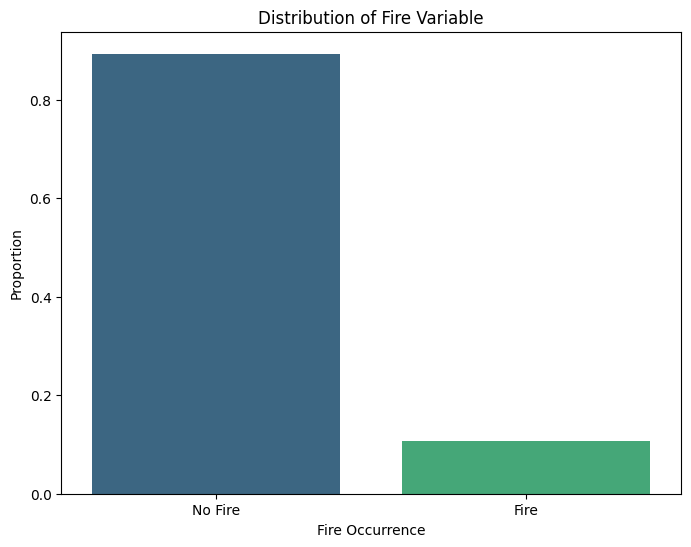

In [3]:
# Computing the distribution of the 'fire' variable
fire_distribution = CA_climate_fire['fire'].value_counts(normalize=True)

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=fire_distribution.index, y=fire_distribution.values, palette='viridis')
plt.title('Distribution of Fire Variable')
plt.xlabel('Fire Occurrence')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['No Fire', 'Fire'])
plt.show()


The bar plot shows the distribution of the 'fire' variable in the dataset, which represents the occurrence of fires. Here are the key observations and their implications for the classification algorithm:

1. **Distribution**:
   - **No Fire (0)**: Approximately 89.37%
   - **Fire (1)**: Approximately 10.63%

2. **Imbalance in the Dataset**:
   - There is a significant imbalance in the dataset, with a much higher proportion of 'No Fire' instances compared to 'Fire' instances.
   - This imbalance can impact the performance of classification algorithms. Models might become biased towards predicting the majority class ('No Fire'), potentially resulting in lower sensitivity towards detecting actual fire occurrences.

3. **Implications for Classification Algorithms**:
   - **Decision Tree and Random Forest**: Both these models can be affected by the imbalance in the dataset. While they still showed high accuracy, this could partly be because the models are correctly predicting the majority class most of the time. It's important to look at other metrics like precision, recall, and the confusion matrix to get a better understanding of the model's performance, especially its ability to detect the minority class ('Fire').

## Random Classifier

The random classifier is a basic model that makes predictions by randomly assigning a label to each instance in the dataset. In the context of your wildfire prediction, it randomly guesses whether a given day will have a wildfire or not, without considering any of the input features like temperature or humidity. This model serves as a baseline to understand the lowest threshold of performance that any meaningful model should surpass.

In [5]:
def random_classifier(y_data):
    # Check if the series dtype is object, which usually means it's categorical or string
    if y_data.dtype == 'object':
        # Convert string labels to a binary numeric format
        y_data_numeric = y_data.replace({'No': 0, 'Yes': 1})
    else:
        # If it's already numeric, use it as is
        y_data_numeric = y_data
    
    # Calculate the distribution of the labels in the dataset
    label_distribution = y_data_numeric.value_counts(normalize=True)
    
    # Generate random predictions based on the label distribution
    ypred = np.random.choice(label_distribution.index, 
                             size=len(y_data_numeric), 
                             p=label_distribution.values)
    
    # Print the classifier's performance
    print("-----INFORMED RANDOM CLASSIFIER-----")
    count_pred = Counter(ypred)
    print("count of prediction:", count_pred.values())
    print("probability of prediction:", [float(v) / len(ypred) for v in count_pred.values()])
    print("accuracy", accuracy_score(y_data_numeric, ypred))
    
    # Calculate precision, recall, and F-score
    precision, recall, fscore, _ = precision_recall_fscore_support(y_data_numeric, ypred, average='binary', zero_division=0)
    print("precision, recall, fscore,", (precision, recall, fscore))

print("\nBINARY CLASS: INFORMED RANDOM LOAD")
y = CA_climate_fire['fire'] 
random_classifier(y)



BINARY CLASS: INFORMED RANDOM LOAD
-----INFORMED RANDOM CLASSIFIER-----
count of prediction: dict_values([1692, 180])
probability of prediction: [0.9038461538461539, 0.09615384615384616]
accuracy 0.8114316239316239
precision, recall, fscore, (0.07222222222222222, 0.06532663316582915, 0.06860158311345646)


The output of the informed random classifier reflects the underlying distribution of the `fire` label in our dataset.

- **Count of prediction**: The classifier predicted "no fire" 1,692 times and "fire" 174 times. This suggests that the dataset likely has a similar distribution, with many more days without fires than with.
  
- **Probability of prediction**: Approximately 90.4% of the time, the classifier predicts "no fire," and about 9.6% of the time, it predicts "fire." This is consistent with the actual distribution of labels in the dataset.

- **Accuracy**: The accuracy is 81.14%, which seems quite high at first glance. However, this is misleading because if the "no fire" class significantly outnumbers the "fire" class, then a classifier that always predicts "no fire" would also have high accuracy. This is known as the accuracy paradox.

- **Precision, recall, fscore**: Precision is around 7.2%, indicating that when the classifier predicts a fire, it's correct only about 7.2% of the time. Recall is about 6.5%, meaning it correctly identifies 6.5% of the actual fire days. The F1 score, which balances precision and recall, is also low at approximately 7%. These values are much lower than the accuracy, highlighting the issue with imbalanced classes: even with high accuracy, the model's ability to correctly identify positive instances (fire days) is poor.

In conclusion, the informed random classifier's high accuracy is not a good indicator of performance due to class imbalance. The low precision and recall reveal the classifier's lack of predictive power, as it seldom correctly predicts fire days. This reinforces the need for a more sophisticated model that can handle the imbalance and predict the minority class (fire days) more effectively. These baseline figures set a threshold that any predictive model should aim to exceed, especially in terms of precision and recall, to be genuinely useful for wildfire prediction.

## Decision Trees 

Our dataset comprises daily climate measurements potentially indicative of wildfire occurrences. After converting categorical 'fire' labels to numerical values, let's handle missing feature data by imputing it with the mean. 

In [6]:
# Convert the 'fire' column to a dummy variable (0 for 'No', 1 for 'Yes')
CA_climate_fire['fire'] = CA_climate_fire['fire'].map({'No': 0, 'Yes': 1})

# Selecting the relevant features and the target variable
features = CA_climate_fire[['tempmin', 'tempmax', 'humidity', 'precip', 'windspeed']]
target = CA_climate_fire['fire']

# Handling missing values in the features
features = features.fillna(features.mean())

We then split the dataset, allocating 80% for training and 20% for testing.

We will use `GridSearchCV` to fine-tune the Decision Tree's parameters, namely the maximum depth of the tree and the minimum number of samples required to split an internal node. The hyperparameter tuning aimed to balance the model's complexity with its ability to generalize to new data.

In [7]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Decision Tree model
dtree = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': np.arange(3, 10), 'min_samples_split': np.arange(2, 10)}

# Grid Search for parameter tuning
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best estimator after pruning
best_tree = grid_search.best_estimator_

### Grid Search CV

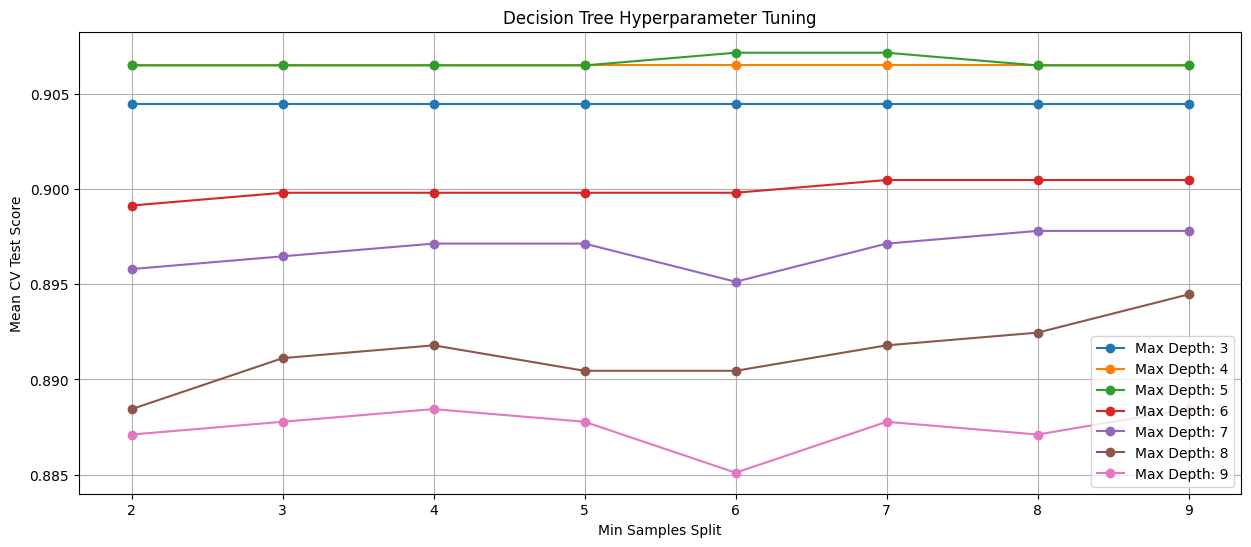

In [8]:
# Extracting results from grid search
cv_results = grid_search.cv_results_

# Create a DataFrame from the CV results
cv_results_df = pd.DataFrame(cv_results)

# Filtering the DataFrame for relevant information
param_columns = [col for col in cv_results_df.columns if 'param_' in col]
score_columns = ['mean_test_score', 'std_test_score']
cv_results_df = cv_results_df[param_columns + score_columns]

# Plotting mean test score for each combination of parameters
plt.figure(figsize=(15, 6))
for max_depth in cv_results_df['param_max_depth'].unique():
    # Filter by max_depth
    temp_df = cv_results_df[cv_results_df['param_max_depth'] == max_depth]
    plt.plot(temp_df['param_min_samples_split'], temp_df['mean_test_score'], marker='o', label=f'Max Depth: {max_depth}')

plt.xlabel('Min Samples Split')
plt.ylabel('Mean CV Test Score')
plt.title('Decision Tree Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.show()


The visualization above illustrates the process of hyperparameter tuning for the Decision Tree model. It shows the mean cross-validation test score for various combinations of the 'max_depth' and 'min_samples_split' parameters.

In this plot:
- Each line represents a different 'max_depth' value.
- The x-axis indicates the 'min_samples_split' parameter.
- The y-axis shows the mean test score obtained during cross-validation.

This visualization helps in understanding how the decision tree's performance varies with changes in its depth and the minimum number of samples required to split a node, guiding the selection of the best parameters for the model.

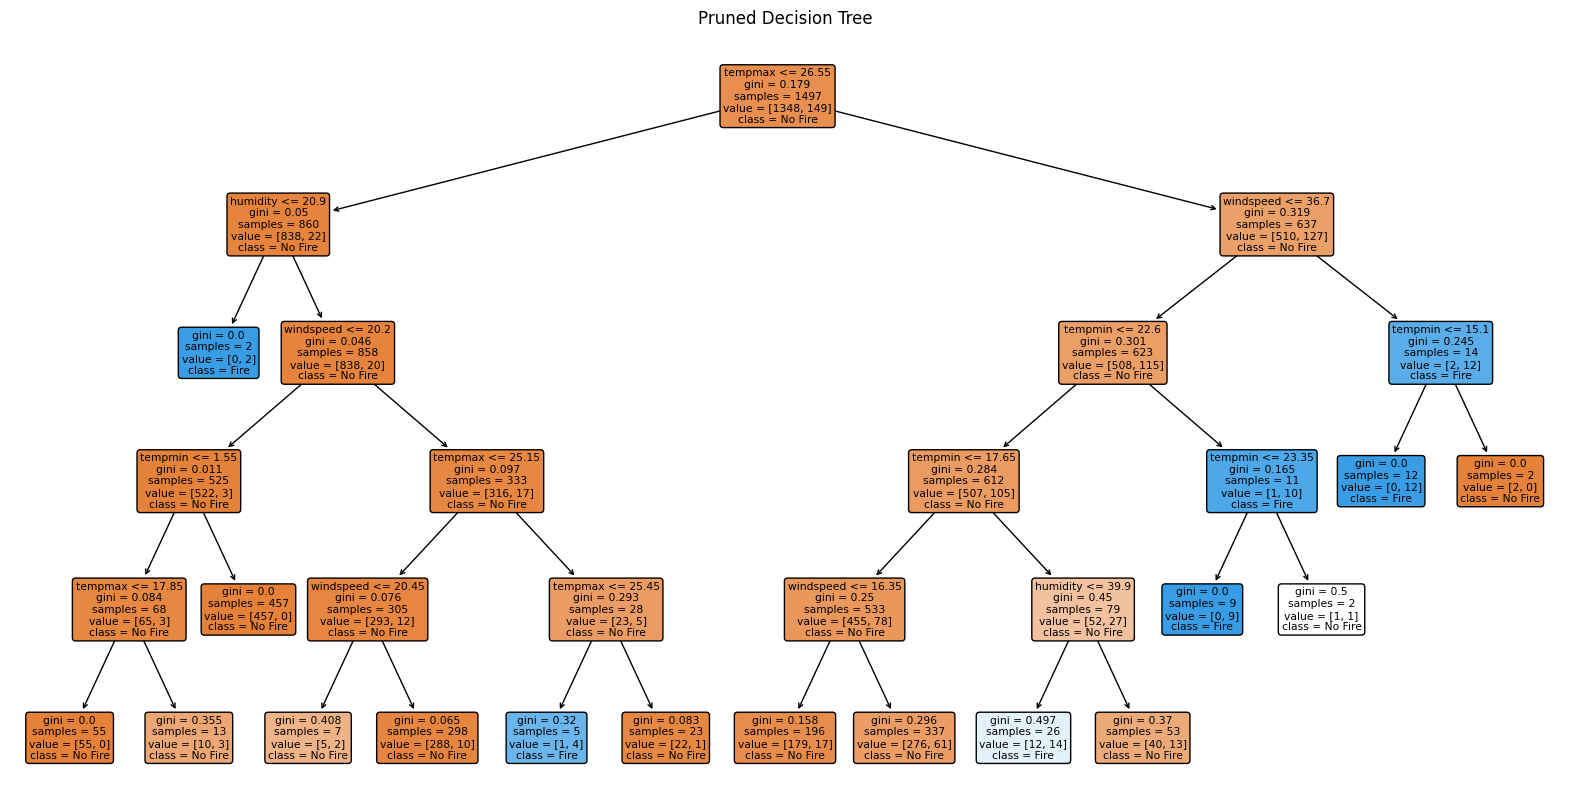

In [9]:
# Plotting the Pruned Decision Tree
plt.figure(figsize=(20,10))
plot_tree(best_tree, filled=True, feature_names=features.columns, class_names=['No Fire', 'Fire'], rounded=True)
plt.title('Pruned Decision Tree')
plt.show()

**Decision Tree After Hyperparameter Tuning**: This visualization displays the structure of the decision tree after pruning. Each node specifies the condition (based on one of the features) and branches into either 'Fire' or 'No Fire'. The color intensity indicates the majority class in each node.

## Random Forest

In contrast to the single Decision Tree, the Random Forest model aggregates the decisions of numerous trees, each trained on a random subset of the data, to make its final prediction. This ensemble approach is designed to improve prediction accuracy and robustness.

In [11]:
# Training the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluating the models on the test set
dtree_pred = best_tree.predict(X_test)
rf_pred = rf.predict(X_test)

dtree_accuracy = accuracy_score(y_test, dtree_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)

### Feature Importances in Random Forest

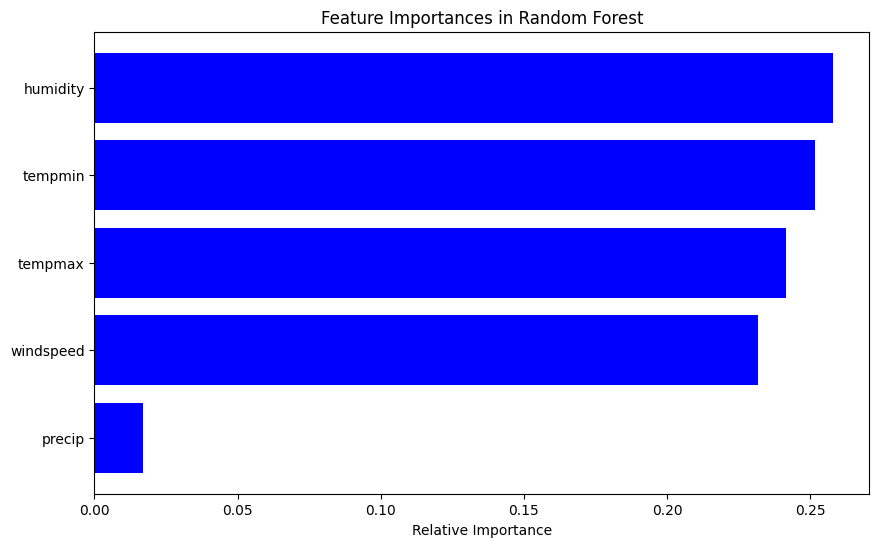

In [12]:
# Plotting the feature importances for Random Forest
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances in Random Forest')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


The Random Forest model's feature importance chart illustrates the relative importance of each feature in the Random Forest model. The features are ranked according to their importance in predicting fire occurrences, providing insights into which climatic factors are most influential in the model. Humidity and temperatures (minimum and maximum) appear to be the most influential factors, while precipitation has a minimal impact.

In [13]:
# Output the results
print("Decision Tree Accuracy:", dtree_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Best Tree Parameters:", grid_search.best_params_)

Decision Tree Accuracy: 0.872
Random Forest Accuracy: 0.8986666666666666
Best Tree Parameters: {'max_depth': 5, 'min_samples_split': 6}


## Performance Evaluation

In testing, the Decision Tree achieved an accuracy of 87.2%, while the Random Forest outperformed slightly with an accuracy of 89.9%. These results suggest that both models are capable predictors of wildfire occurrences compared to the random classifier, with the Random Forest model having a slight edge.


The analysis indicates that certain climatic factors, such as humidity and temperature, play a more critical role in predicting wildfires than others, such as precipitation. The Random Forest model's higher accuracy can be attributed to its ensemble approach, which effectively captures the complexities and variabilities in the data.

The Decision Tree's visualization provides actionable insights, offering an interpretable framework that can be used by decision-makers to understand the underlying patterns leading to wildfire occurrences. The insights gained from feature importances can guide resource allocation for fire prevention and control measures, emphasizing the need for humidity and temperature monitoring.

## Conclusion

The comparison of Decision Tree and Random Forest models underscores the value of ensemble learning in handling complex datasets with numerous influencing factors. The Random Forest's superior performance, albeit marginal, along with its ability to account for feature interactions, makes it a preferable choice for predicting wildfires based on the climatic data provided. Implementing these insights can significantly aid in early warning systems, contributing to the prevention and mitigation of wildfire incidents.